# Import Necessary Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

# Defining Labels

In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Loading Dataset


In [3]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('Data/brain-tumor-mri-dataset/', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('Data/brain-tumor-mri-dataset', 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 43.81it/s]


In [4]:
X_train.shape #No of sample = 7023

(7023, 150, 150, 3)

In [5]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [6]:
#After shuffling sample size remains same
X_train.shape

(7023, 150, 150, 3)

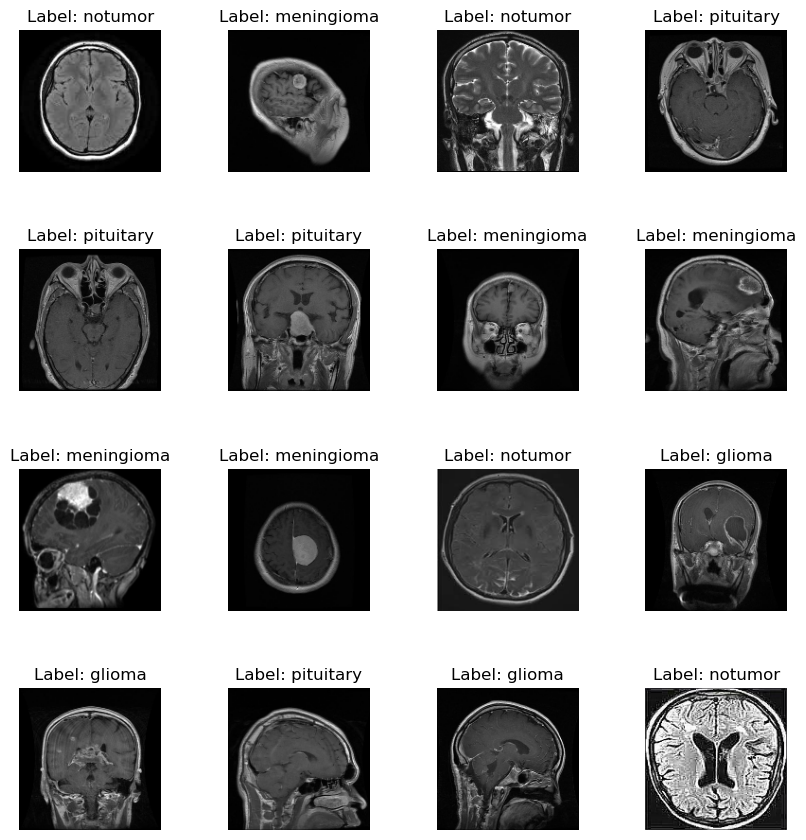

In [7]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Converting String Label to categorical

In [9]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [10]:
Y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

# Simple CNN Model

In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [12]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['Acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

# Scaling Features : Train, Valid and Test 

In [ ]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# Training the model

In [14]:
history = model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=10,
                   verbose=1)

158/158 [==============================] - 193s 1s/step - loss: 0.1594 - Acc: 0.9419 - val_loss: 0.2841 - val_Acc: 0.9110
Epoch 4/10
158/158 [==============================] - 188s 1s/step - loss: 0.0911 - Acc: 0.9688 - val_loss: 0.2488 - val_Acc: 0.9075
Epoch 5/10
158/158 [==============================] - 160s 1s/step - loss: 0.0597 - Acc: 0.9802 - val_loss: 0.3084 - val_Acc: 0.9324
Epoch 6/10
158/158 [==============================] - 161s 1s/step - loss: 0.0490 - Acc: 0.9844 - val_loss: 0.2820 - val_Acc: 0.9217
Epoch 7/10
158/158 [==============================] - 159s 1s/step - loss: 0.0509 - Acc: 0.9856 - val_loss: 0.2313 - val_Acc: 0.9359
Epoch 8/10
158/158 [==============================] - 194s 1s/step - loss: 0.0151 - Acc: 0.9956 - val_loss: 0.3443 - val_Acc: 0.9288
Epoch 9/10
158/158 [==============================] - 192s 1s/step - loss: 0.0236 - Acc: 0.9915 - val_loss: 0.3938 - val_Acc: 0.9413
Epoch 10/10
158/158 [==============================] - 185s 1s/step - loss: 0.02

# Accuracy and Loss Visualization

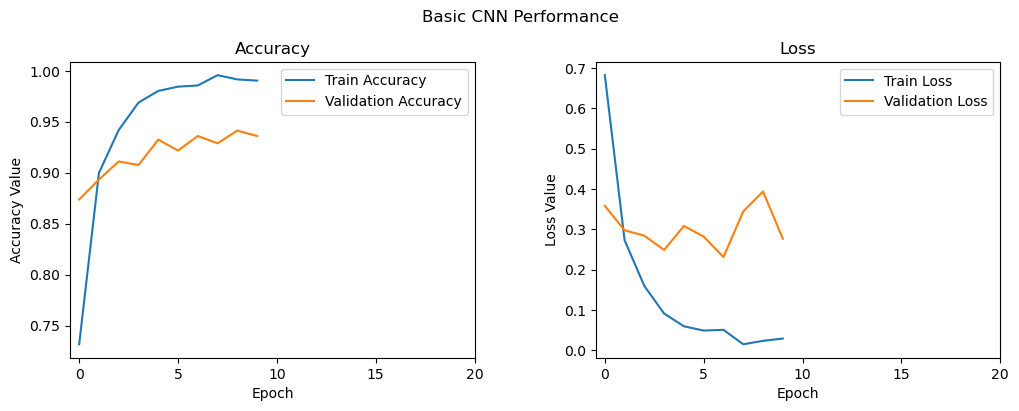

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(history.history['Acc'], label='Train Accuracy')
ax1.plot(history.history['val_Acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Model Saving

In [18]:
model.save('Basic_CNN.h5')

# Getting model predictions : Classification Report

In [19]:
# Getting model predictions
test_predictions = model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

44/44 [==============================] - 39s 286ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       310
           1       0.87      0.93      0.90       326
           2       0.98      0.96      0.97       419
           3       0.97      0.97      0.97       350

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405



# Showing Confusion Matrix

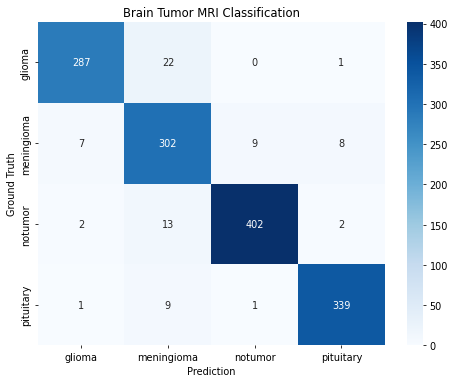

In [20]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

# Plotting roc curve

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

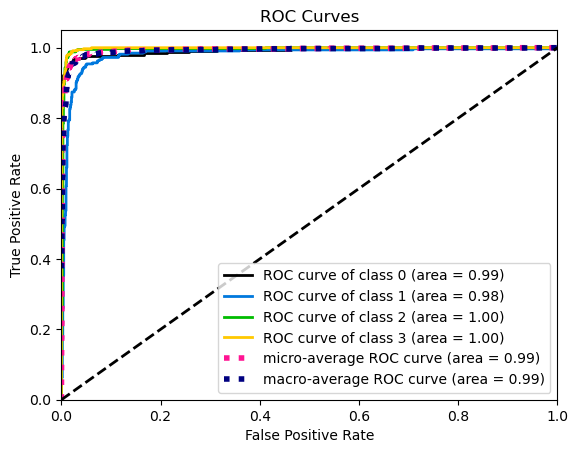

In [21]:
skplt.metrics.plot_roc(actual_label, test_predictions)

# Visualizing Model Predictions with Confidence

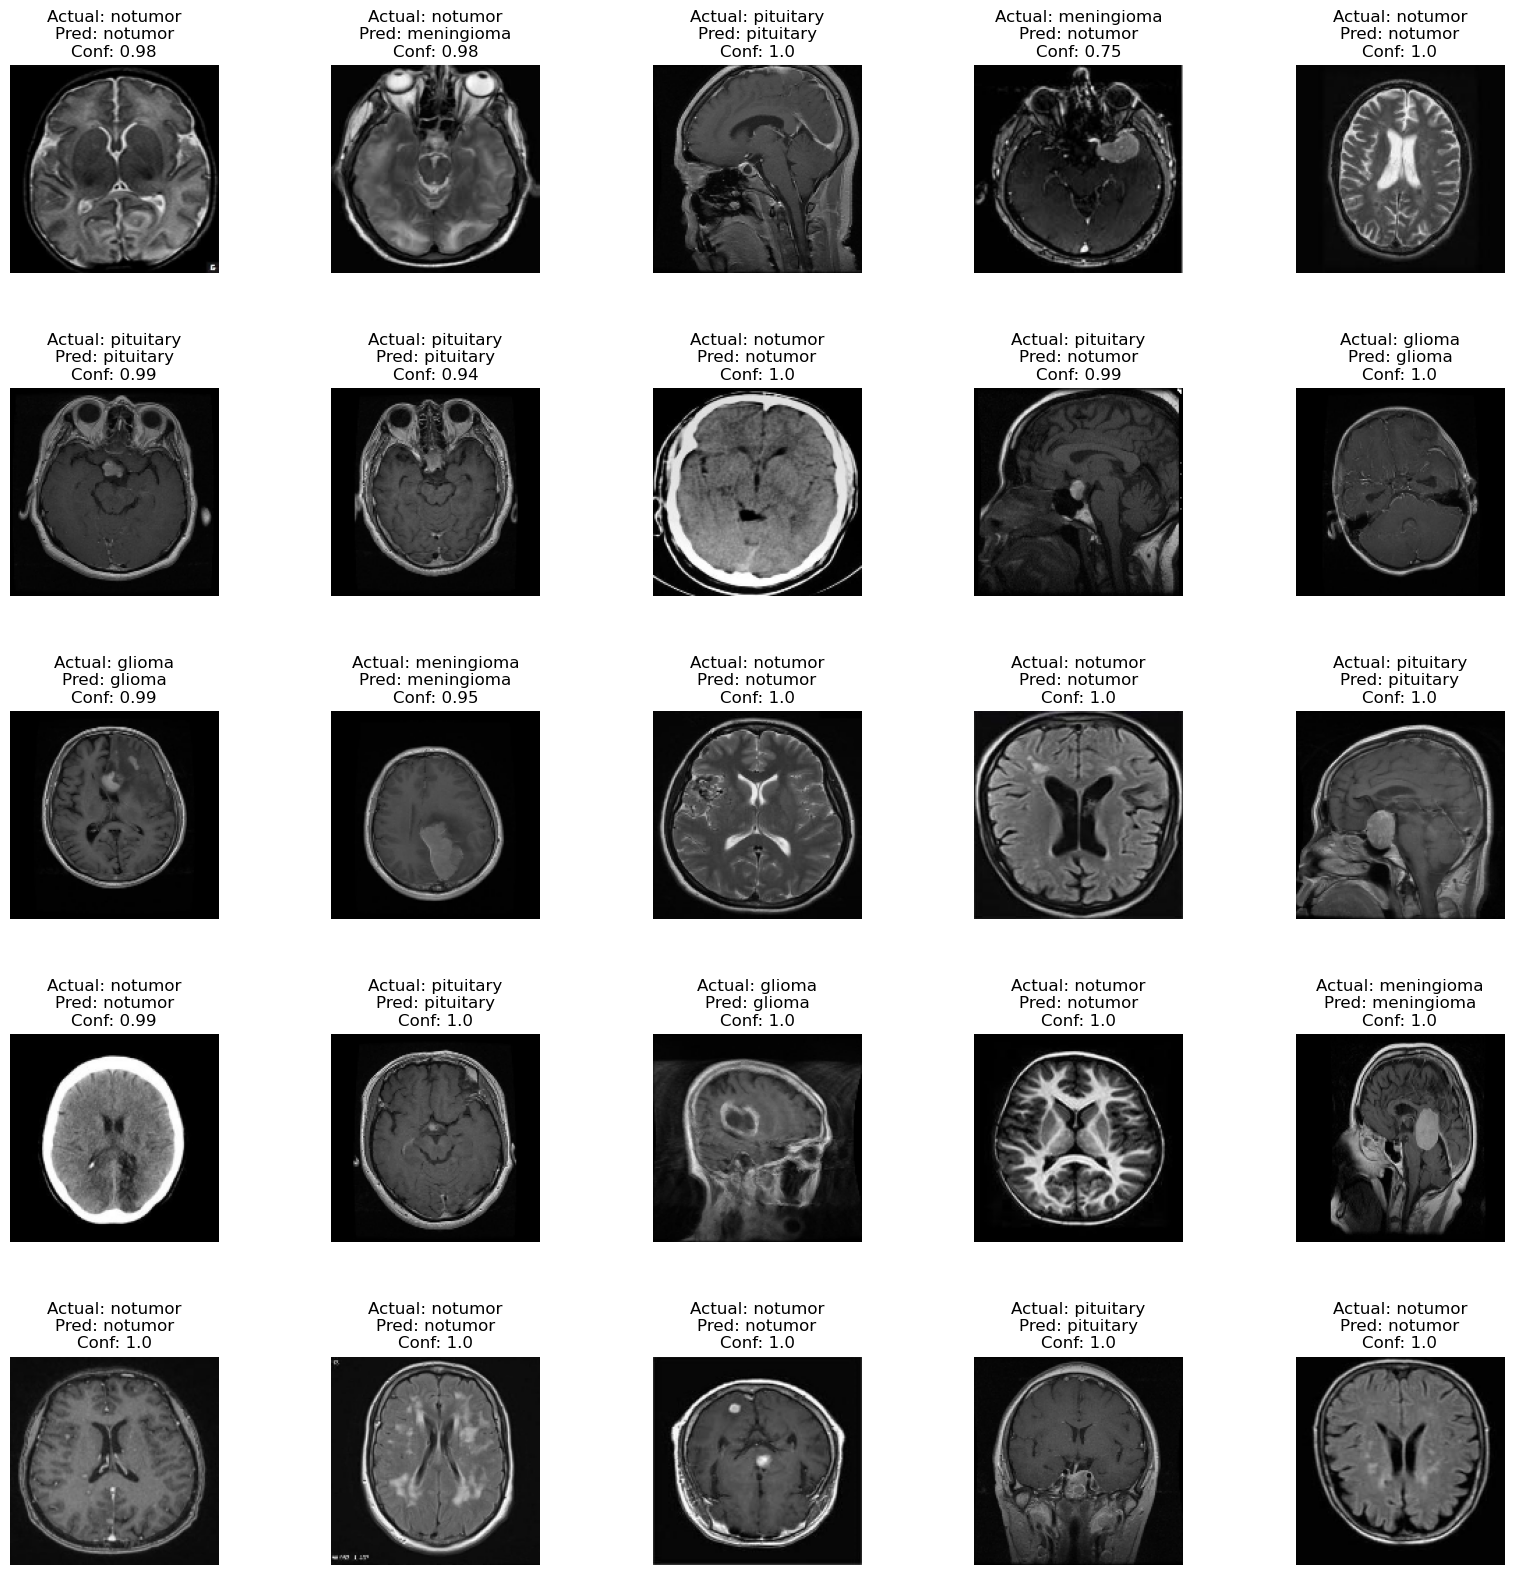

In [22]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = preds[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   